# More Data Cleaning and Feature Engineering
1) Determine the language of each transcript.

2) Get runtime and rating info from IMDb.

3) Remove whitespace and any unwanted characters.

4) Tokenize words with Gensim, remove stopwords (from NLTK.corpus) and count them.

5) Count swear words. This might be useful for classification later on.

6) Use WordCloud as a way to get the gist of a transcript.

KDE plots are used throughout to make sure everything looks right. Quickly viewing a simple distribution can be a great indicator that the code and data are performing as expected.

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(color_codes=True)
%config InlineBackend.figure_formats = ['retina']

In [2]:
df = pd.read_csv('stand-up-data.csv')
df.head()

,title,date_posted,link,name,year,transcript
0,Russell Peters: Deported,"May 10th, 2020",https://scrapsfromtheloft.com/2020/05/10/russe...,Russell Peters,2020.0,"NARRATOR: Ladies and gentlemen, it’s start t..."
1,Jimmy O. Yang: Good Deal,"May 10th, 2020",https://scrapsfromtheloft.com/2020/05/10/jimmy...,Jimmy O. Yang,2020.0,"ANNOUNCER: Ladies and gentlemen, welcome to th..."
2,Jo Koy: Lights Out,"May 9th, 2020",https://scrapsfromtheloft.com/2020/05/09/jo-ko...,Jo Koy,2012.0,"L.A., are you ready? Live from the Alex Thea..."
3,Lee Mack: Going Out Live,"May 8th, 2020",https://scrapsfromtheloft.com/2020/05/08/lee-m...,Lee Mack,2010.0,This programme contains strong language Over ...
4,Lee Mack: Live,"May 7th, 2020",https://scrapsfromtheloft.com/2020/05/07/lee-m...,Lee Mack,2007.0,"PRESENTER: Ladies and gentlemen, please welco..."


### Use the langdetect library to id the languages of each transcript

In [3]:
from langdetect import detect

# Dectect language based on the first 500 characters and create a language column in the df
df['language'] = df.transcript.apply(lambda x: detect(x[:500]))

print(df.language.value_counts())
df.head()

en    322
it      7
es      1
Name: language, dtype: int64


,title,date_posted,link,name,year,transcript,language
0,Russell Peters: Deported,"May 10th, 2020",https://scrapsfromtheloft.com/2020/05/10/russe...,Russell Peters,2020.0,"NARRATOR: Ladies and gentlemen, it’s start t...",en
1,Jimmy O. Yang: Good Deal,"May 10th, 2020",https://scrapsfromtheloft.com/2020/05/10/jimmy...,Jimmy O. Yang,2020.0,"ANNOUNCER: Ladies and gentlemen, welcome to th...",en
2,Jo Koy: Lights Out,"May 9th, 2020",https://scrapsfromtheloft.com/2020/05/09/jo-ko...,Jo Koy,2012.0,"L.A., are you ready? Live from the Alex Thea...",en
3,Lee Mack: Going Out Live,"May 8th, 2020",https://scrapsfromtheloft.com/2020/05/08/lee-m...,Lee Mack,2010.0,This programme contains strong language Over ...,en
4,Lee Mack: Live,"May 7th, 2020",https://scrapsfromtheloft.com/2020/05/07/lee-m...,Lee Mack,2007.0,"PRESENTER: Ladies and gentlemen, please welco...",en


### Get runtime and rating info with an IMDb api
For the most part, only fully produced specials will have data on IMDb. Only 52 titles from our original set of 300+ were not found on IMDb.

In [4]:
import imdb

imdb = imdb.IMDb()

def get_imdb_info(titles):
    runtime = []
    rating = []
    count = -1
    errors = 0
    
    for i in titles:
        count += 1
        # Search the first 30 characters on IMDb
        result = imdb.search_movie(i[:30])
        try:
            mov = imdb.get_movie(result[0].movieID, info=['main'])
            runtime.append(int(mov.get('runtimes')[0]))
            rating.append(mov.get('rating'))
        except:
            runtime.append('')
            rating.append('')
            errors += 1
            # print(f'Error on index {count}, title: {i}') # Uncomment to investigate which titles were not found
    print(f'Total not found: {errors}')
    return pd.Series(runtime), pd.Series(rating)
    
runtime, rating = get_imdb_info(df.title)

df['runtime'] = runtime
df['rating'] = rating

# Replace empty values with NaN
df = df.replace(r'^\s*$', np.NaN, regex=True)

df.head()

Total not found: 52


,title,date_posted,link,name,year,transcript,language,runtime,rating
0,Russell Peters: Deported,"May 10th, 2020",https://scrapsfromtheloft.com/2020/05/10/russe...,Russell Peters,2020.0,"NARRATOR: Ladies and gentlemen, it’s start t...",en,67.0,6.1
1,Jimmy O. Yang: Good Deal,"May 10th, 2020",https://scrapsfromtheloft.com/2020/05/10/jimmy...,Jimmy O. Yang,2020.0,"ANNOUNCER: Ladies and gentlemen, welcome to th...",en,NaN,NaN
2,Jo Koy: Lights Out,"May 9th, 2020",https://scrapsfromtheloft.com/2020/05/09/jo-ko...,Jo Koy,2012.0,"L.A., are you ready? Live from the Alex Thea...",en,59.0,7.8
3,Lee Mack: Going Out Live,"May 8th, 2020",https://scrapsfromtheloft.com/2020/05/08/lee-m...,Lee Mack,2010.0,This programme contains strong language Over ...,en,60.0,7.2
4,Lee Mack: Live,"May 7th, 2020",https://scrapsfromtheloft.com/2020/05/07/lee-m...,Lee Mack,2007.0,"PRESENTER: Ladies and gentlemen, please welco...",en,68.0,7.7


### Simplify rating value by creating a rating_type feature
Give a 1 for any rating above the mean (approximately 7.34), and a 0 otherwise. This will be our target for a classification task later on.

[Text(0.5, 1.0, 'Counts of specials with higher or lower than average ratings')]

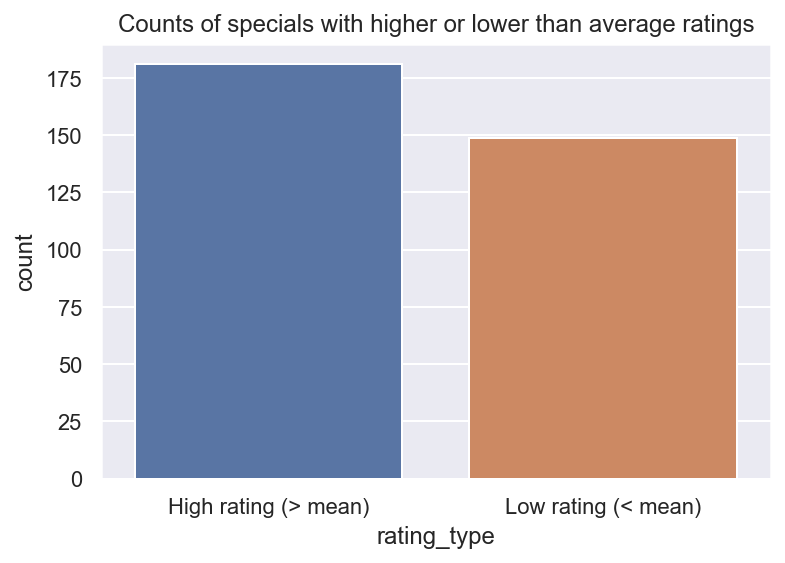

In [5]:


df['rating_type'] = df.rating.apply(lambda x: 1 if x >= df.rating.mean() else 0)

ax = sns.countplot(x='rating_type', data=df)
ax.set(xticklabels=['High rating (> mean)', 'Low rating (< mean)'])
ax.set(title='Counts of specials with higher or lower than average ratings')

### Perform some simple visualization to make sure everything looks right

Mean: 67.96043165467626
SD: 14.930602626073169


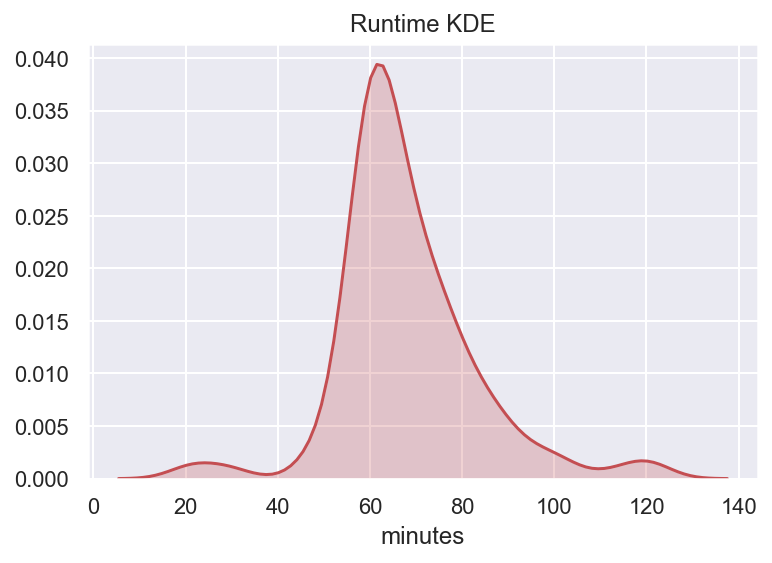

In [6]:
import numpy as np
import seaborn as sns; sns.set(color_codes=True)

# Stats and KDE plot for runtime of each performance
x = []
count = 0
for i in df.runtime:
    if (i > 0):
        count += 1
        x.append(int(i))
ax = sns.kdeplot(x, shade=True, color="r")   
ax.set_title('Runtime KDE')
ax.set(xlabel='minutes')
mean = np.array(x).mean()
sd = np.array(x).std()
print(f'Mean: {mean}')
print(f'SD: {sd}')

Mean: 7.33705035971223
SD: 0.9029694842851724


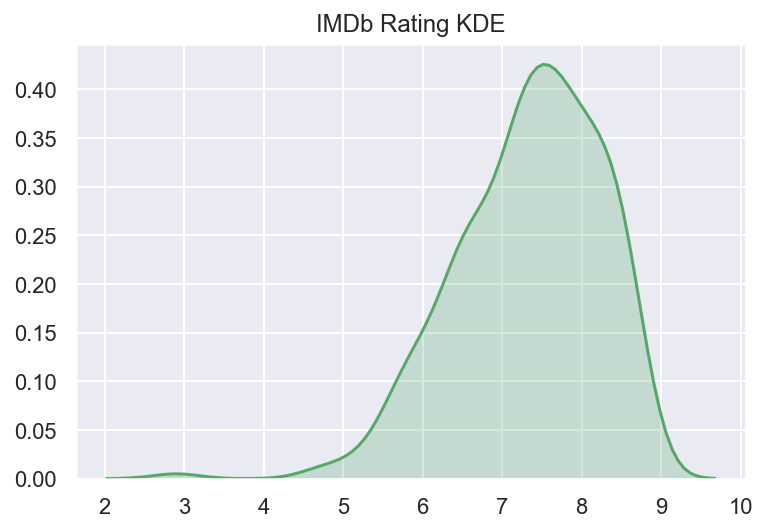

In [7]:
# Stats and KDE plot for IMDb rating of each performance
x = []
count = 0
for i in df.rating:
    if (i > 0):
        count += 1
        x.append(i)
ax = sns.kdeplot(x, shade=True, color="g")   
ax.set_title('IMDb Rating KDE')
mean = np.array(x).mean()
sd = np.array(x).std()
print(f'Mean: {mean}')
print(f'SD: {sd}')

### Tokenize words with Gensim simple_preprocess method

In [8]:
from nltk.corpus import stopwords
from gensim.utils import simple_preprocess

stop_words = stopwords.words('english')

# Tokenize, lowercase, and remove stopwords in one line
df['words'] = df.transcript.apply(lambda x: [word for word in simple_preprocess(x) if word not in stop_words])

# Get word count
df['word_count'] = df.words.apply(lambda x: len(x))

### Count the number of times an 'F' or 'S' words used

In [9]:
def get_swear_counts(input_list, swear_list):
    swears = 0
    for word in input_list:
        if word.lower()in swear_list:
            swears += 1
    return swears

f_words = ['fuck', 'fucking', 'fuckin', 'fucker', 'fucka']
s_words = ['shit', 'shitter', 'shitting', 'shite', 'bullshit']

df['f_words'] = df.words.apply(lambda x: get_swear_counts(x, f_words))
df['s_words'] = df.words.apply(lambda x: get_swear_counts(x, s_words))

Mean: 42.35757575757576
SD: 45.816463707806754


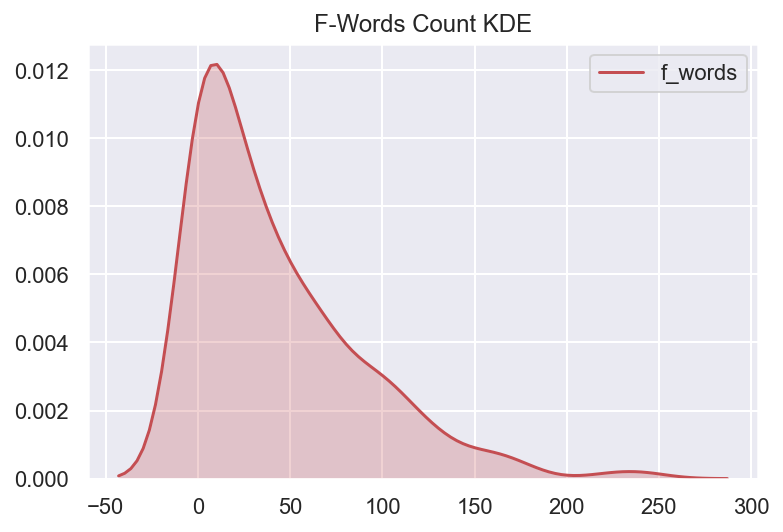

In [10]:
ax = sns.kdeplot(df.f_words, shade=True, color="r")
ax.set_title('F-Words Count KDE')
mean = df.f_words.mean()
sd = df.f_words.std()
print(f'Mean: {mean}')
print(f'SD: {sd}')

Mean: 24.172727272727272
SD: 29.97999102468657


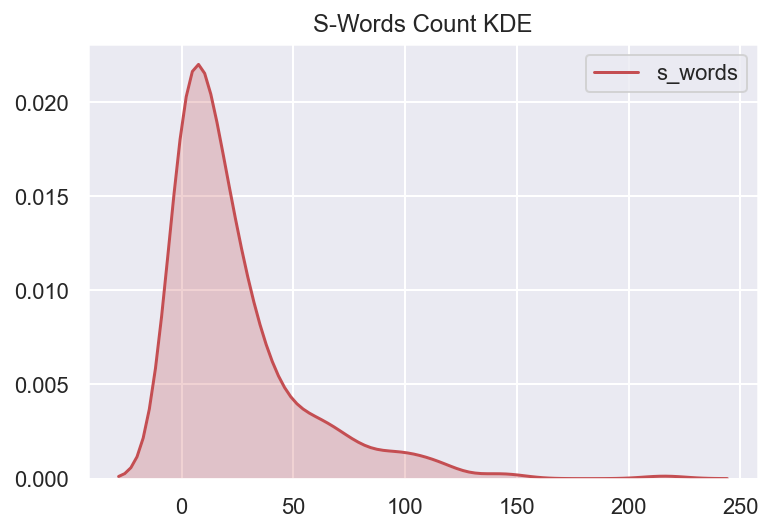

In [11]:
ax = sns.kdeplot(df.s_words, shade=True, color="r")
ax.set_title('S-Words Count KDE')
mean = df.s_words.mean()
sd = df.s_words.std()
print(f'Mean: {mean}')
print(f'SD: {sd}')

### Use word cloud to visualize the most common words.
This can be used to glean the flavor of a transcripts at a glance.

The Standups: Gina Yashere    


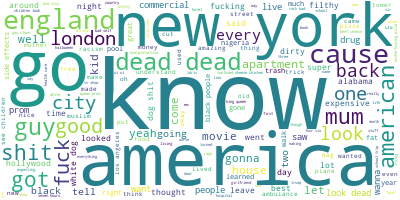

In [12]:
from wordcloud import WordCloud

print(df.title[60])
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud.generate(' '.join(df.words[60]))
wordcloud.to_image()

Vir Das: Losing It    


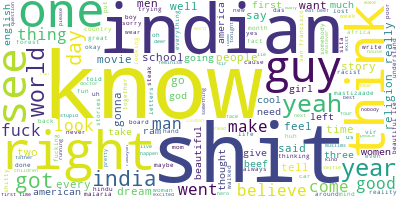

In [13]:
print(df.title[90])
wordcloud.generate(' '.join(df.words[90]))
wordcloud.to_image()

### Create diversity and diversity_ratio features
These hand-build features will give us information about the diversity of vocabulary each comedian uses. 

The diversity_ratio feature is a simple ratio: (diversity of words) / (total words)

In [14]:
df['diversity'] = df.words.apply(lambda x: len(set(x)))
df['diversity_ratio'] = df.diversity / df.word_count

Mean: 1264.2424242424242
SD: 466.32634191226896


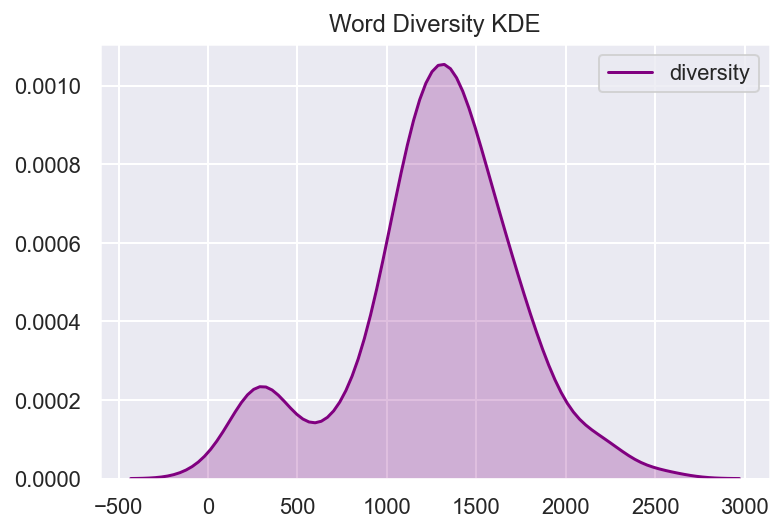

In [15]:
ax = sns.kdeplot(df.diversity, shade=True, color="purple")
ax.set_title('Word Diversity KDE')
mean = df.diversity.mean()
sd = df.diversity.std()
print(f'Mean: {mean}')
print(f'SD: {sd}')

Mean: 0.36224681830457095
SD: 0.10384778385096849


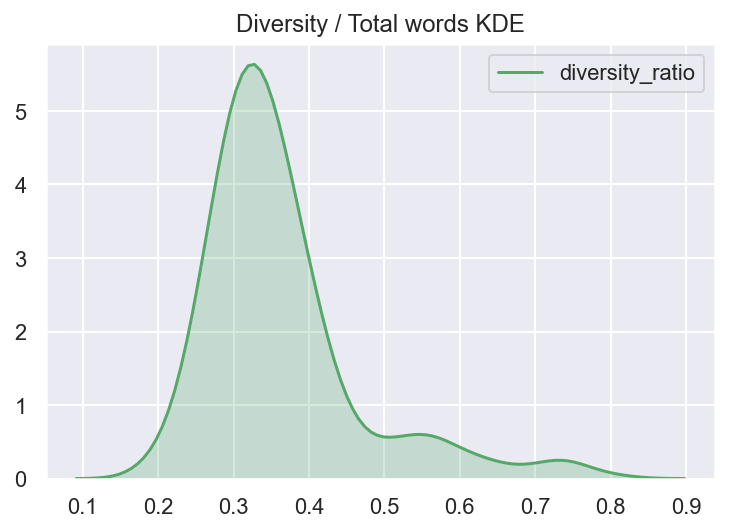

In [16]:
ax = sns.kdeplot(df.diversity_ratio, shade=True, color="g")
ax.set_title('Diversity / Total words KDE')
mean = df.diversity_ratio.mean()
sd = df.diversity_ratio.std()
print(f'Mean: {mean}')
print(f'SD: {sd}')

### Use a pairplot visualization to discover any interesting correlations
There are some interesting relationships between word_count, diversity, and diversity_ratio as would be expected. Unfortunately there doesn't seem to be any simple correlations between rating or rating_type and any of the other features we currently have.

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


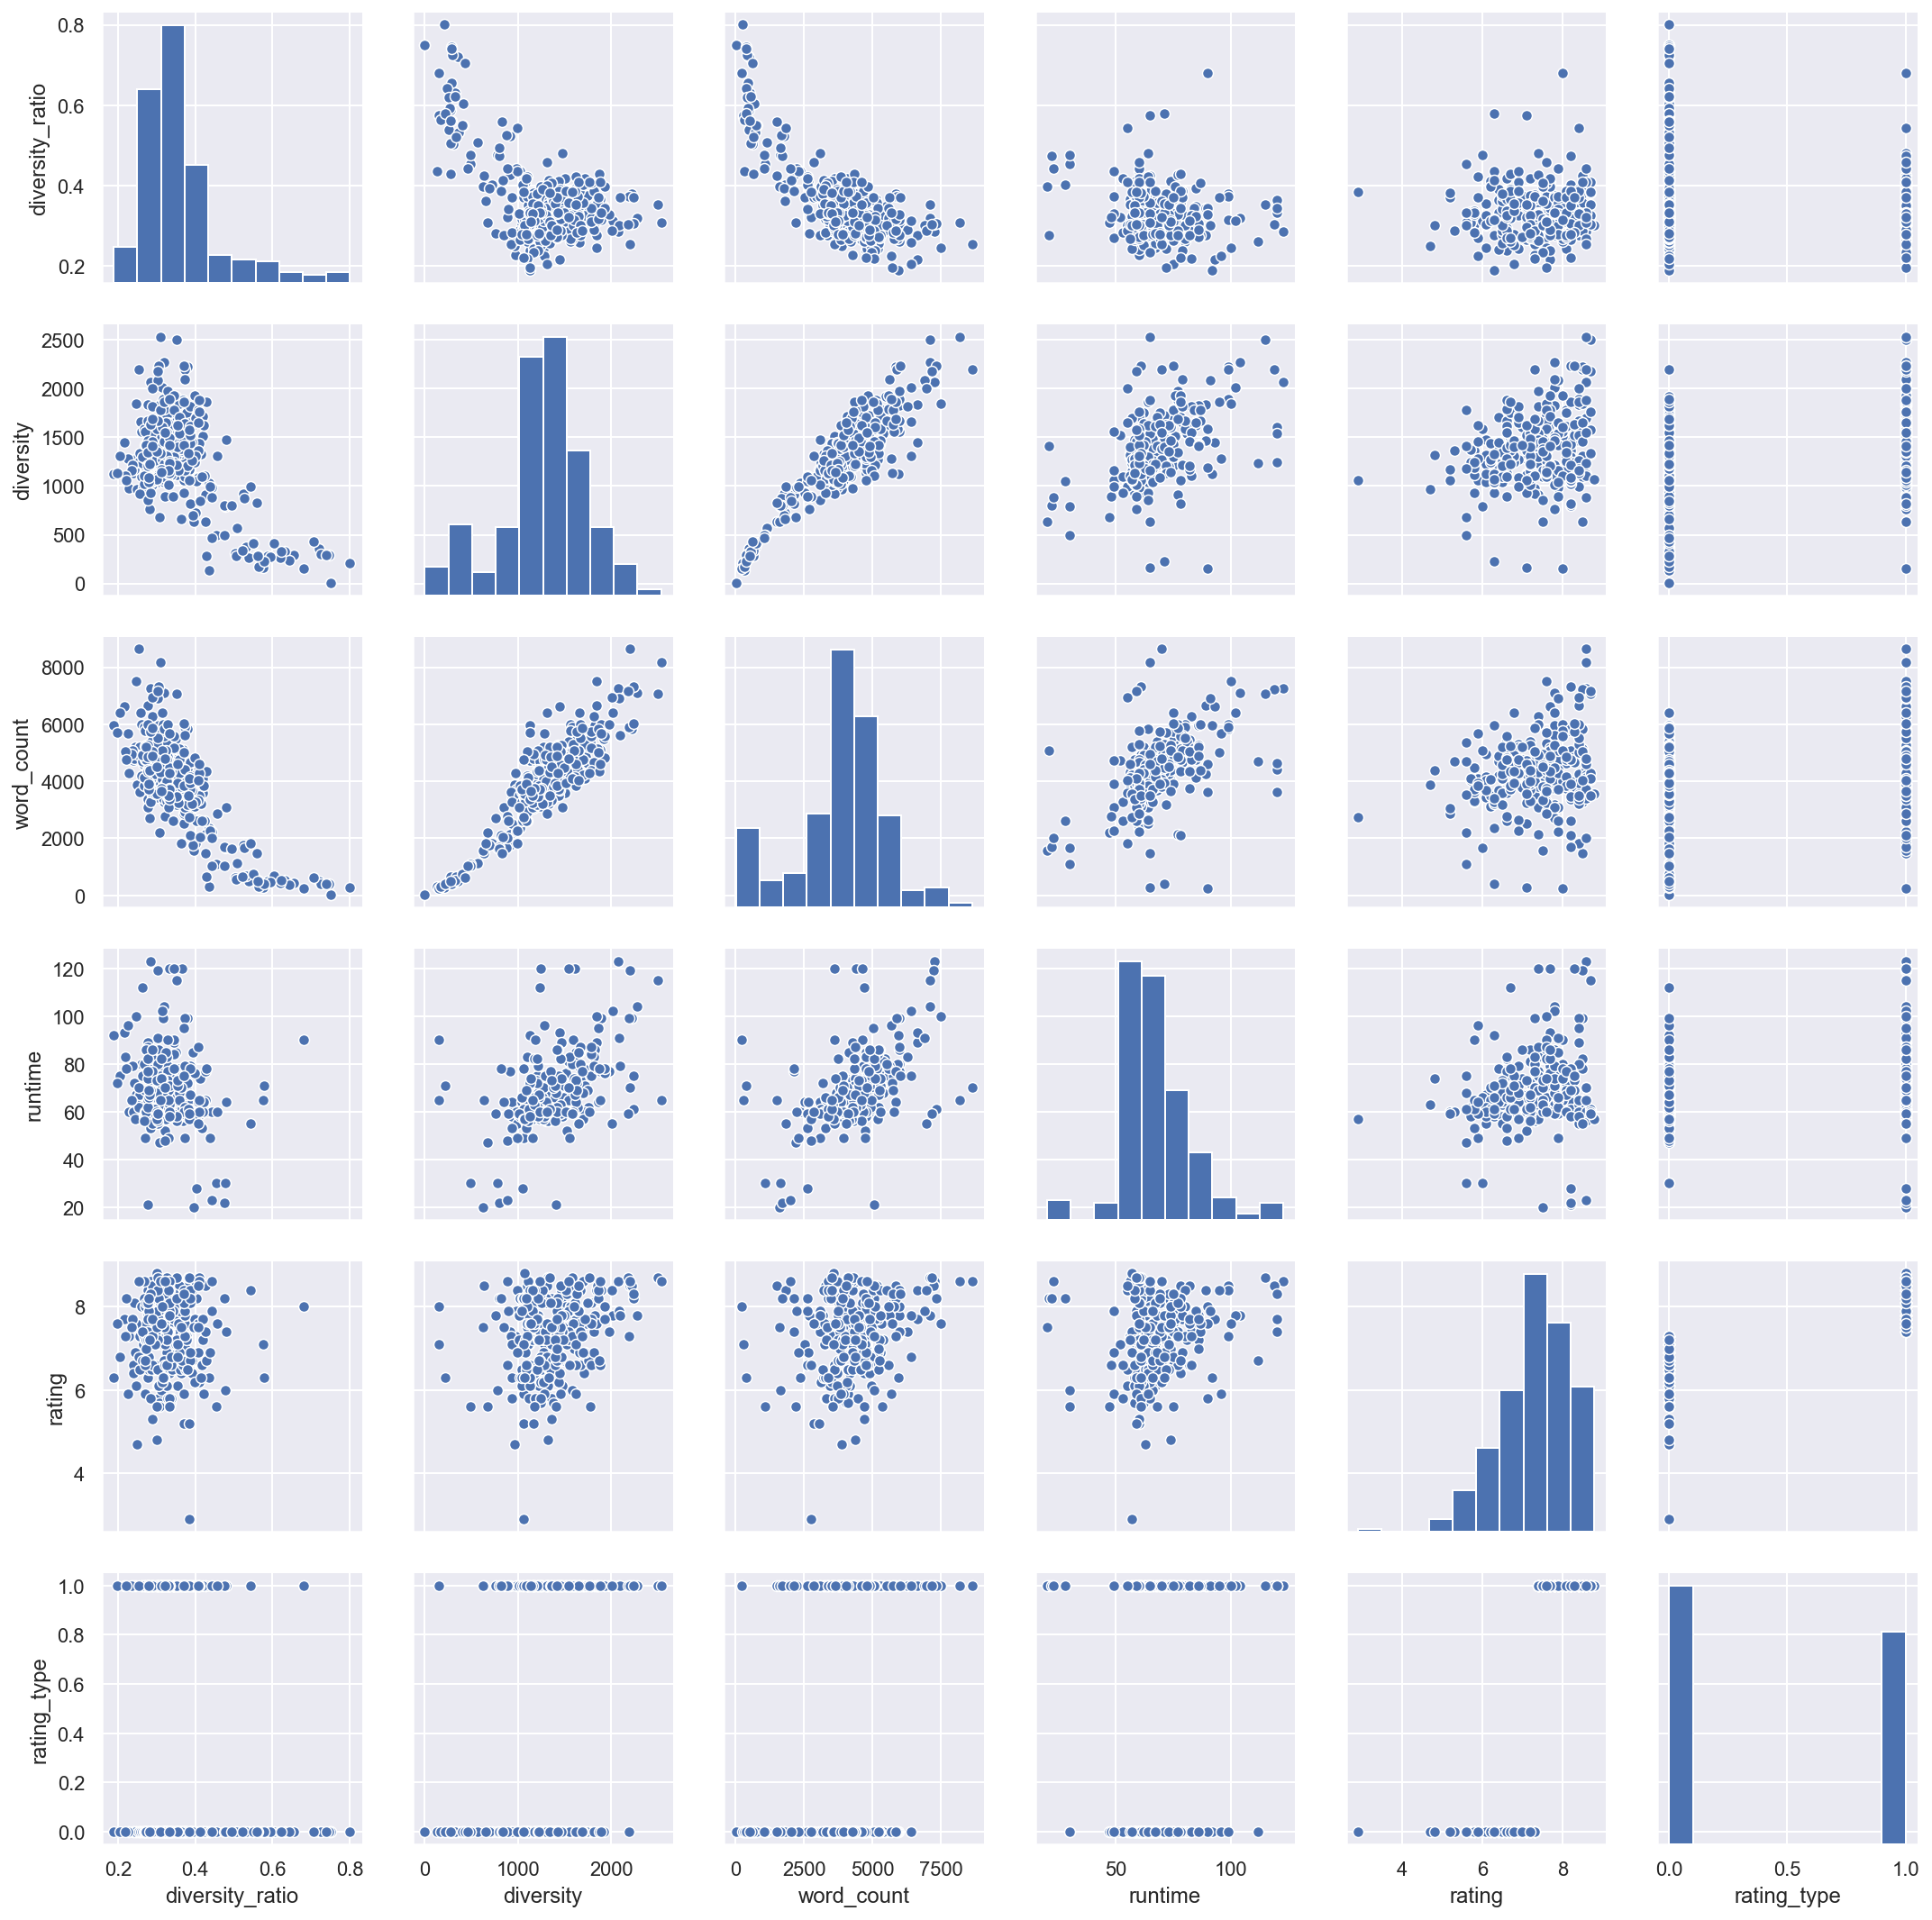

In [17]:
sns.pairplot(df[['diversity_ratio', 'diversity', 'word_count', 'runtime', 'rating', 'rating_type']])

In [18]:
df.head()

,title,date_posted,link,name,year,transcript,language,runtime,rating,rating_type,words,word_count,f_words,s_words,diversity,diversity_ratio
0,Russell Peters: Deported,"May 10th, 2020",https://scrapsfromtheloft.com/2020/05/10/russe...,Russell Peters,2020.0,"NARRATOR: Ladies and gentlemen, it’s start t...",en,67.0,6.1,0,"[narrator, ladies, gentlemen, start, time, dom...",4954,63,30,1223,0.246871
1,Jimmy O. Yang: Good Deal,"May 10th, 2020",https://scrapsfromtheloft.com/2020/05/10/jimmy...,Jimmy O. Yang,2020.0,"ANNOUNCER: Ladies and gentlemen, welcome to th...",en,NaN,NaN,0,"[announcer, ladies, gentlemen, welcome, stage,...",4118,26,39,1247,0.302817
2,Jo Koy: Lights Out,"May 9th, 2020",https://scrapsfromtheloft.com/2020/05/09/jo-ko...,Jo Koy,2012.0,"L.A., are you ready? Live from the Alex Thea...",en,59.0,7.8,1,"[ready, live, alex, theatre, give, jo, koy, oh...",2696,45,35,759,0.281528
3,Lee Mack: Going Out Live,"May 8th, 2020",https://scrapsfromtheloft.com/2020/05/08/lee-m...,Lee Mack,2010.0,This programme contains strong language Over ...,en,60.0,7.2,0,"[programme, contains, strong, language, dates,...",4044,33,5,1443,0.356825
4,Lee Mack: Live,"May 7th, 2020",https://scrapsfromtheloft.com/2020/05/07/lee-m...,Lee Mack,2007.0,"PRESENTER: Ladies and gentlemen, please welco...",en,68.0,7.7,1,"[presenter, ladies, gentlemen, please, welcome...",5388,101,19,1693,0.314217


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330 entries, 0 to 329
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   title            330 non-null    object 
 1   date_posted      330 non-null    object 
 2   link             330 non-null    object 
 3   name             326 non-null    object 
 4   year             313 non-null    float64
 5   transcript       330 non-null    object 
 6   language         330 non-null    object 
 7   runtime          278 non-null    float64
 8   rating           278 non-null    float64
 9   rating_type      330 non-null    int64  
 10  words            330 non-null    object 
 11  word_count       330 non-null    int64  
 12  f_words          330 non-null    int64  
 13  s_words          330 non-null    int64  
 14  diversity        330 non-null    int64  
 15  diversity_ratio  330 non-null    float64
dtypes: float64(4), int64(5), object(7)
memory usage: 41.4+ KB


### Save data into a csv file for more analysis later on

In [20]:
# Save DataFrame to the current drectory
df.to_csv(r'./stand-up-data-cleaned.csv', index=False)